# Proyecto Integrador

## Score de Riesgo en Originación de Crédito
## Para Kubo Financiero

Participantes:

Dalina Aideé Villa Ocelotl (A01793258)

Julián Valera Juarez (A01793875)

Miguel Guillermo Galindo Orozco (A01793695)
1793695)

## Avance 5. Modelo final

In [4]:
# !pip install xgboost
# !pip install matplotlib pandas

### Importar librerías

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import time
from sklearn.metrics import f1_score

**Leer datos**

In [8]:
file_path = 'base_20210101a20240430 (2).xlsx'
df = pd.read_excel(file_path, sheet_name='Cliientes_Nuevos')

**Eliminar variables no necesarias**

In [10]:
variables_eliminar = ["montocredito_actual", "estatus_actual","diasatraso_actual","saldo_actual"]
variables_ok = [i for i in df.columns if i not in variables_eliminar ]
df = df[variables_ok]
df = df[df['es_malo_actual'].isin([0,1])]
df = df.dropna()

**Separar variables independientes (x) y dependientes (y)**

In [12]:
y = df['es_malo_actual']
X = df.drop(columns=['es_malo_actual'])

**Eliminar columnas datetime y convertir categorias en dummy**

In [14]:
X = X.select_dtypes(exclude=['datetime64'])
X = pd.get_dummies(X, drop_first=True)

**Escalar datos**

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Separar conjuntos de entrenamiento (train) y prueba (test)**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1234, shuffle=True)

**Definir los modelos individuales**

In [20]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

**Definir la cuadrícula de hiperparámetros para algunos modelos**

In [22]:
param_grid = {
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

**Optimización de hiperparámetros y entrenamiento de modelos**

In [24]:
best_models = {}
for name, model in models.items():
    if name in param_grid:
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
    else:
        model.fit(X_train, y_train)
        best_models[name] = model

**Modelos de ensamble**

In [26]:
voting_clf = VotingClassifier(estimators=[
    ('rf', best_models['Random Forest']),
    ('gb', best_models['Gradient Boosting']),
    ('xgb', best_models['XGBoost'])
], voting='soft')
voting_clf.fit(X_train, y_train)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', best_models['Random Forest']),
        ('gb', best_models['Gradient Boosting']),
        ('xgb', best_models['XGBoost'])
    ], final_estimator=LogisticRegression(max_iter=2000)
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_split=5,
                                                       n_estimators=200)),
                               ('gb',
                                GradientBoostingClassifier(n_estimators=200)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categori...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression(max_iter=2000))

**Función para evaluar los modelos**

In [28]:
def evaluate_model(name, model, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]
    end_time = time.time()
    
    auc_score = roc_auc_score(y_test, y_probs)
    acc_score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    training_time = end_time - start_time
    
    return {
        'Model': name,
        'ROC-AUC': auc_score,
        'Accuracy': acc_score,
        'F1-Score': f1,
        'Training Time (s)': training_time
    }

# Evaluación
results = []
for name, model in {**best_models, 'Voting Classifier': voting_clf, 'Stacking Classifier': stacking_clf}.items():
    results.append(evaluate_model(name, model, X_test, y_test))

**Resultados de evaluación**

In [30]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='ROC-AUC', ascending=False)
print(results_df)

                 Model   ROC-AUC  Accuracy  F1-Score  Training Time (s)
7    Voting Classifier  0.699122  0.798465  0.020718           0.391783
8  Stacking Classifier  0.698971  0.799176  0.094811           0.389965
6              XGBoost  0.697226  0.799744  0.057525           0.015010
2    Gradient Boosting  0.695959  0.799034  0.049731           0.046817
1        Random Forest  0.692721  0.797897  0.000000           0.376175
0  Logistic Regression  0.649140  0.796049  0.013746           0.007011
5          Naive Bayes  0.593184  0.714895  0.271076           0.032597
3                  SVC  0.581105  0.797328  0.001401          26.344067
4                  KNN  0.558248  0.762933  0.137539           1.065080


**Se crea un diccionario con todos los modelos**

In [32]:
all_models = {}
for model_name, model in best_models.items():
    all_models[model_name] = model
all_models['Voting Classifier'] = voting_clf
all_models['Stacking Classifier'] = stacking_clf

**Se obtiene el mejor modelo (basado en árboles)**

In [34]:
tree_based_models = ['Random Forest', 'Gradient Boosting', 'XGBoost']
best_tree_model_name = results_df[results_df['Model'].isin(tree_based_models)].iloc[0]['Model']
best_tree_model = all_models[best_tree_model_name]
print(f"El mejor modelo es: {best_tree_model_name}")

El mejor modelo es: XGBoost


**Curva ROC**

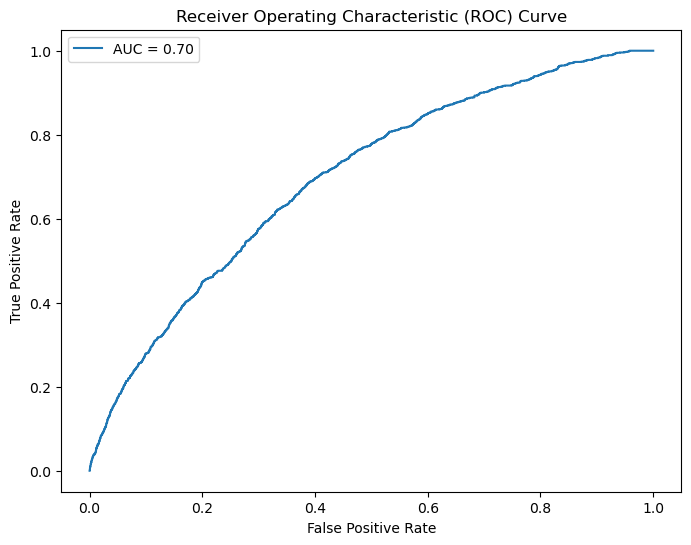

In [36]:
y_probs = best_tree_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

**Matriz de confusión**

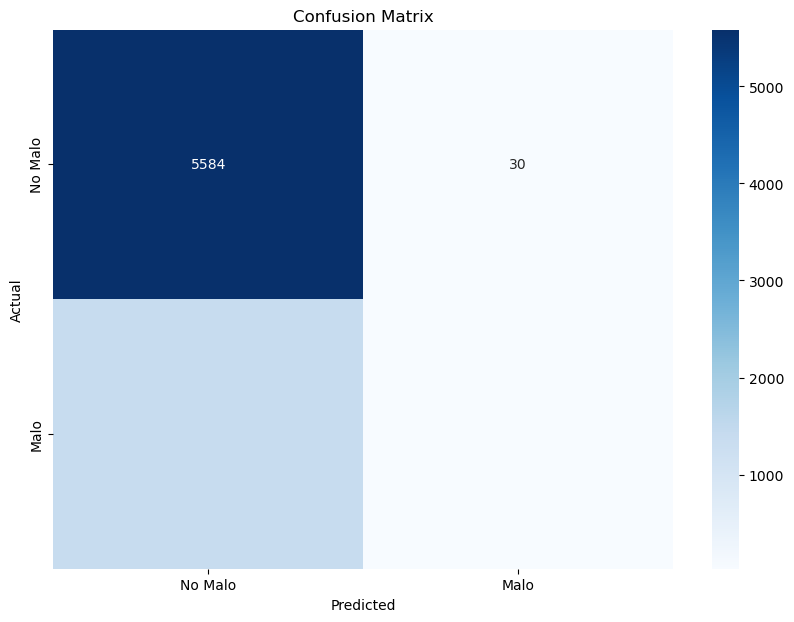

In [38]:
y_pred = best_tree_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Malo', 'Malo'], yticklabels=['No Malo', 'Malo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Curva de Precisión-Recall**

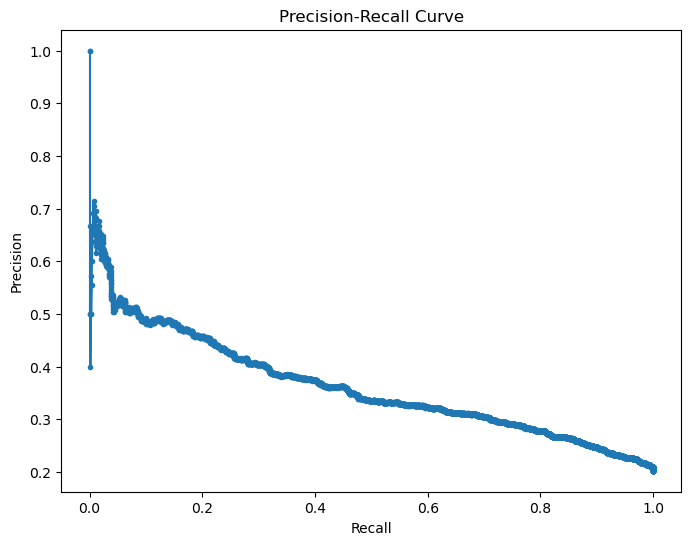

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

**Importancia de características**

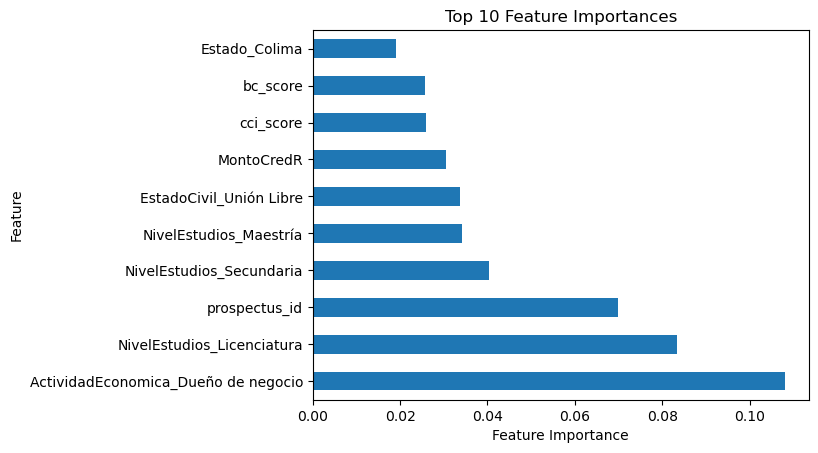

In [42]:
if hasattr(best_tree_model, 'feature_importances_'):
    feature_importances = pd.Series(best_tree_model.feature_importances_, index=X.columns)
    feature_importances.nlargest(10).plot(kind='barh')
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()